# Import

## Packages

In [1]:
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

In [2]:
pd.set_option('display.max_column', 500)
pd.set_option('display.max_row',500)
pd.set_option('float_format', '{:f}'.format)

## Data

* 國道五號為台灣易塞車路段，2020年端午連假塞車情況嚴重，因此先選定2020年6月為分析資料

In [3]:
!pwd

/Users/cyc/Documents/python_learning/projects/ETC


In [ ]:
root_path = '/Users/cyc/Documents/python_learning/projects/ETC/data/M05A/'

date_list = []
for i in range(1, 31):
    if i < 10:
        num = str(f'0{i}')
    else:
        num = str(i)
    date_list.append(num)

hh_list = []
for i in range(0, 24):
    if i < 10:
        hh = str(f'0{i}')
    else:
        hh = str(i)
    hh_list.append(hh)


df_all = pd.DataFrame()
files_list = []

for d in date_list:   
    for hh in hh_list:
        dd = '202006'+d+'/'
        path = root_path+str(dd)+str(hh)+'/'
        files_list = os.listdir(path)
        for file in files_list:
            df_tmp = pd.read_csv(path+file, header=None)
            df_all = df_all.append(df_tmp)
        

In [38]:
df_all.columns=['TimeInterval', 'GantryFrom', 'GantryTo', 'VehicleType', 'SpaceMeanSpeed', 'Traffic']

# Data processing

In [41]:
df_all.head()

,TimeInterval,GantryFrom,GantryTo,VehicleType,SpaceMeanSpeed,Traffic
0,2020/06/01 00:10,01F0017N,01F0005N,31,75,23
1,2020/06/01 00:10,01F0017N,01F0005N,32,75,6
2,2020/06/01 00:10,01F0017N,01F0005N,41,64,1
3,2020/06/01 00:10,01F0017N,01F0005N,42,0,0
4,2020/06/01 00:10,01F0017N,01F0005N,5,0,0


In [42]:
df_all.dtypes

TimeInterval      object
GantryFrom        object
GantryTo          object
VehicleType        int64
SpaceMeanSpeed     int64
Traffic            int64
dtype: object

In [44]:
df_all.shape

(18014400, 6)

## 時間資訊

In [50]:
df_all['yyyymm']=df_all['TimeInterval'].str[:4]+df_all['TimeInterval'].str[5:7]
df_all['yyyymmdd']=df_all['TimeInterval'].str[:4]+df_all['TimeInterval'].str[5:7]+df_all['TimeInterval'].str[8:10]
df_all['hh']=df_all['TimeInterval'].str[11:13]

In [41]:
df_all['mmdd'] = df_all['yyyymmdd'].str[4:]

In [75]:
# 假日:1 平日:0
df_all['date_type'] = np.where(
                      (df_all['yyyymmdd']=='20200606')|(df_all['yyyymmdd']=='20200607')|\
                      (df_all['yyyymmdd']=='20200613')|(df_all['yyyymmdd']=='20200614')|\
                      (df_all['yyyymmdd']=='20200621')|\
                      (df_all['yyyymmdd']=='20200625')|(df_all['yyyymmdd']=='20200626')|
                      (df_all['yyyymmdd']=='20200627')|(df_all['yyyymmdd']=='20200628'), 1, 0)

## 路段資訊

In [78]:
# 前2碼為國道編號
df_all['road_no_from']=df_all['GantryFrom'].str[:2]
df_all['road_no_to']=df_all['GantryTo'].str[:2]

# F:國道 H快速道路
df_all['road_type_from']=df_all['GantryFrom'].str[2:3]
df_all['road_type_to']=df_all['GantryTo'].str[2:3]

# 四碼數字：路段公里數
df_all['road_level_from']=df_all['GantryFrom'].str[3:7]
df_all['road_level_to']=df_all['GantryTo'].str[3:7]

# N:北向 S:南向
df_all['road_dir_from']=df_all['GantryFrom'].str[7:8]
df_all['road_dir_to']=df_all['GantryTo'].str[7:8]


## 車輛資訊

In [101]:
# 31,32:小型車  41,42:大型車  5:連結車

df_all['VehicleSize'] = np.where((df_all['VehicleType']==31)|(df_all['VehicleType']==32), 1,
                                 np.where((df_all['VehicleType']==41)|(df_all['VehicleType']==42), 2, 3
                                 ))

In [43]:
# df_all.to_pickle('etc_202006.pkl')

In [ ]:
# df_all = pd.read_pickle('etc_202006.pkl')

## 限定國道五號

In [44]:
df_05 = df_all[(df_all['road_no_from']=='05')&(df_all['road_no_to']=='05')]

In [45]:
df_05['speed_traffic'] = df_05['SpaceMeanSpeed']*df_05['Traffic']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
# df_05.to_pickle('etc_202006_05.pkl')

In [52]:
df_05.columns

Index(['TimeInterval', 'GantryFrom', 'GantryTo', 'VehicleType',
       'SpaceMeanSpeed', 'Traffic', 'yyyymm', 'yyyymmdd', 'hh', 'road_no_from',
       'road_no_to', 'road_type_from', 'road_type_to', 'road_level_from',
       'road_level_to', 'road_dir_from', 'road_dir_to', 'date_type',
       'VehicleSize', 'mmdd', 'speed_traffic'],
      dtype='object')

## 車種

In [53]:
group_col = ['TimeInterval', 'GantryFrom', 'GantryTo', 
       'yyyymm', 'yyyymmdd', 'mmdd', 'hh', 'road_no_from',
       'road_no_to', 'road_type_from', 'road_type_to', 'road_level_from',
       'road_level_to', 'road_dir_from', 'road_dir_to', 'date_type',
       'VehicleSize']

df_05_g = df_05.groupby(group_col)['Traffic'].sum().reset_index()
df_05_tmp = df_05.groupby(group_col)['speed_traffic'].sum().reset_index()

df_05_g['speed_traffic'] = df_05_tmp['speed_traffic']
df_05_g['avg_speed'] = df_05_tmp['speed_traffic']/df_05_g['Traffic']


In [54]:
df_05_g.to_pickle('etc_202006_05_cartype.pkl')

In [5]:
# df_05_g = pd.read_pickle('etc_202006_05_cartype.pkl')

# EDA

![title](F05.png)

* 大型車、連結車車流相對很少，後續分析鎖定小型車

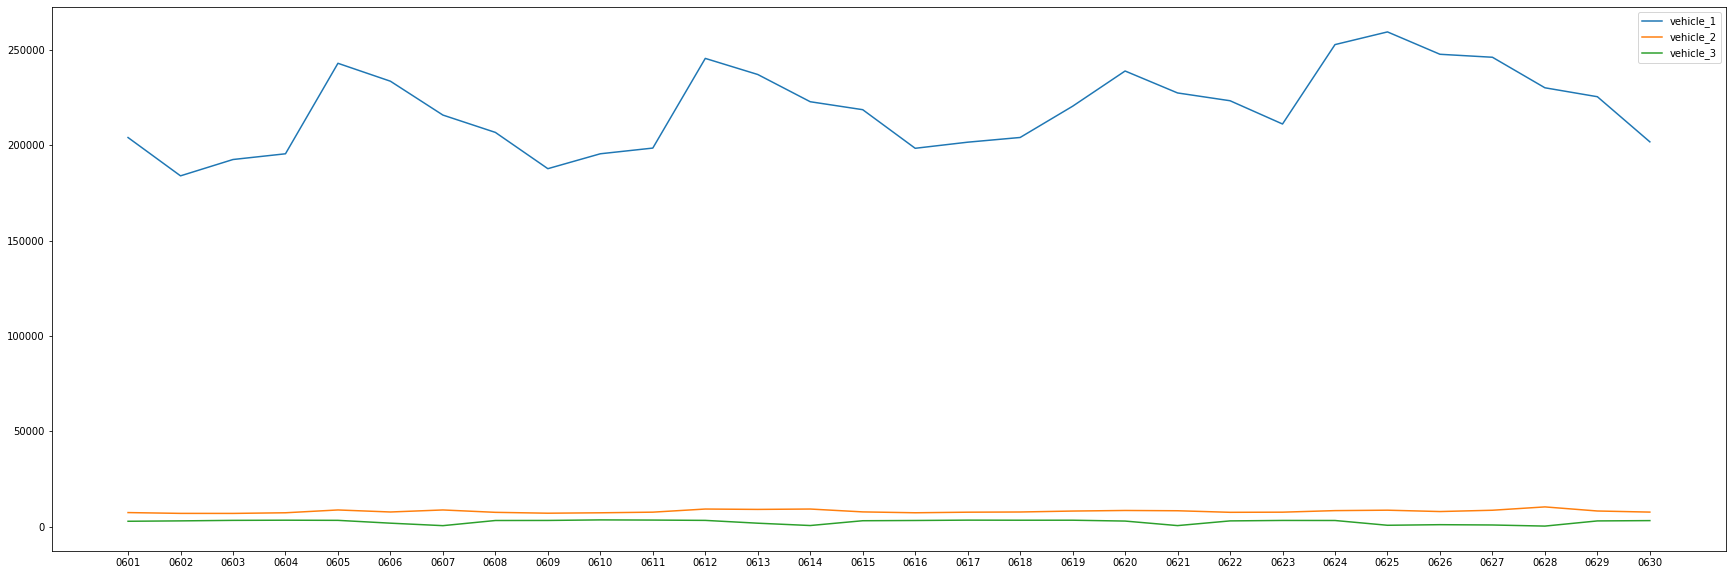

In [64]:
df_v1 = df_05_g[df_05_g['VehicleSize']==1].groupby('mmdd')['Traffic'].sum().reset_index()
df_v2 = df_05_g[df_05_g['VehicleSize']==2].groupby('mmdd')['Traffic'].sum().reset_index()
df_v3 = df_05_g[df_05_g['VehicleSize']==3].groupby('mmdd')['Traffic'].sum().reset_index()

plt.figure(figsize=(30, 10))

plt.plot(df_v1['mmdd'], df_v1['Traffic'], label='vehicle_1')
plt.plot(df_v2['mmdd'], df_v2['Traffic'], label='vehicle_2')
plt.plot(df_v3['mmdd'], df_v3['Traffic'], label='vehicle_3')

plt.legend()

## 路段

### 北上路段

In [56]:
df_n = df_05_g[(df_05_g['road_dir_to']=='N')&(df_05_g['VehicleSize']==1)]

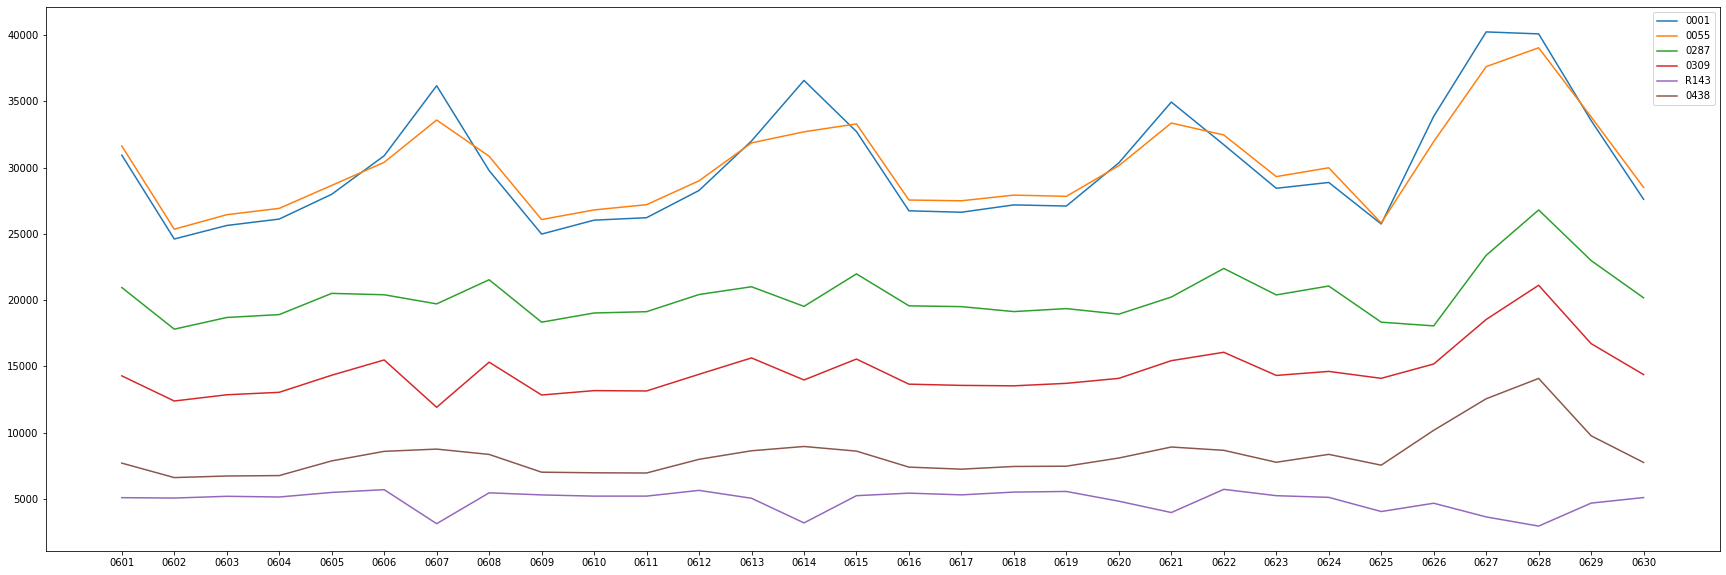

In [57]:
df_n_01 = df_n[df_n['road_level_to']=='0001'].groupby('mmdd')['Traffic'].sum().reset_index()
df_n_02 = df_n[df_n['road_level_to']=='0055'].groupby('mmdd')['Traffic'].sum().reset_index()
df_n_03 = df_n[df_n['road_level_to']=='0287'].groupby('mmdd')['Traffic'].sum().reset_index()
df_n_04 = df_n[df_n['road_level_to']=='0309'].groupby('mmdd')['Traffic'].sum().reset_index()
df_n_05 = df_n[df_n['road_level_to']=='R143'].groupby('mmdd')['Traffic'].sum().reset_index()
df_n_06 = df_n[df_n['road_level_to']=='0438'].groupby('mmdd')['Traffic'].sum().reset_index()

plt.figure(figsize=(30, 10))

plt.plot(df_n_01['mmdd'], df_n_01['Traffic'], label='0001')
plt.plot(df_n_02['mmdd'], df_n_02['Traffic'], label='0055')
plt.plot(df_n_03['mmdd'], df_n_03['Traffic'], label='0287')
plt.plot(df_n_04['mmdd'], df_n_04['Traffic'], label='0309')
plt.plot(df_n_05['mmdd'], df_n_05['Traffic'], label='R143')
plt.plot(df_n_06['mmdd'], df_n_06['Traffic'], label='0438')

plt.legend()

### 南下路段

In [58]:
df_s = df_05_g[(df_05_g['road_dir_to']=='S')&(df_05_g['VehicleSize']==1)]

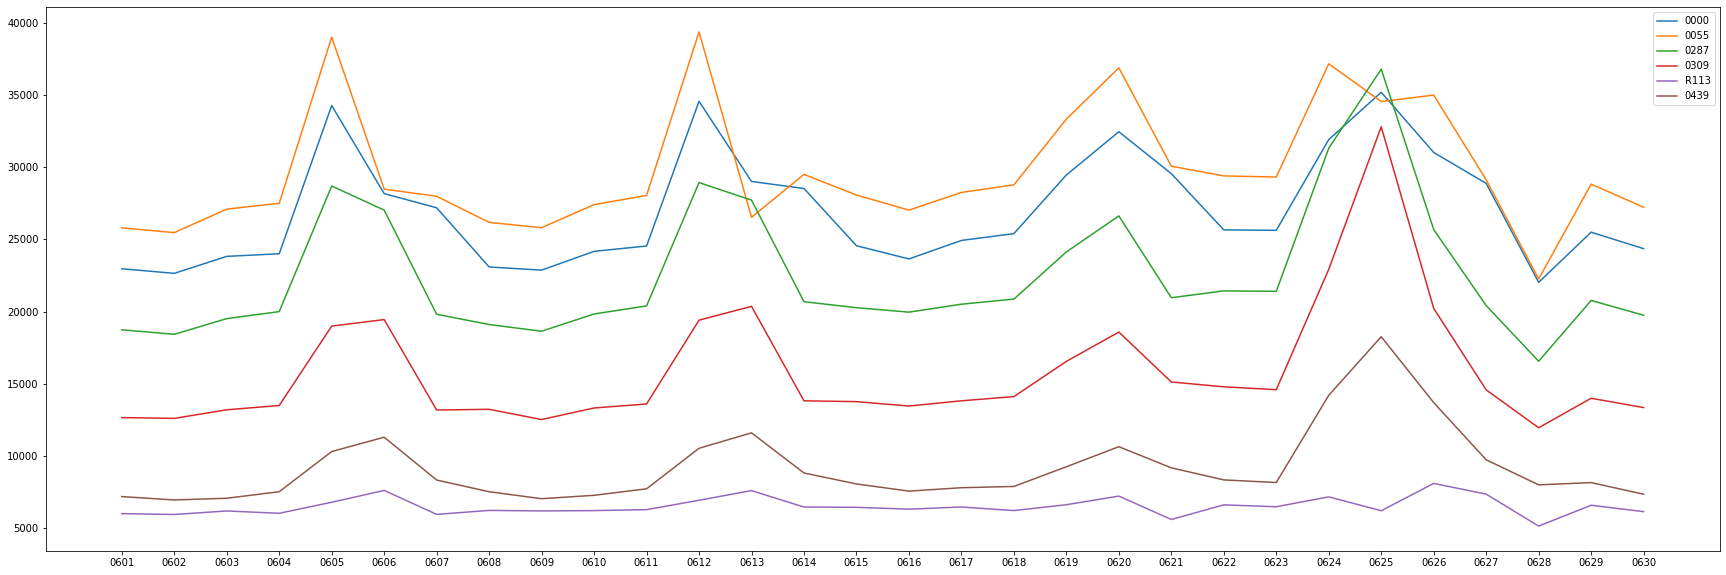

In [65]:
df_s_01 = df_s[df_s['road_level_from']=='0000'].groupby('mmdd')['Traffic'].sum().reset_index()
df_s_02 = df_s[df_s['road_level_from']=='0055'].groupby('mmdd')['Traffic'].sum().reset_index()
df_s_03 = df_s[df_s['road_level_from']=='0287'].groupby('mmdd')['Traffic'].sum().reset_index()
df_s_04 = df_s[df_s['road_level_from']=='0309'].groupby('mmdd')['Traffic'].sum().reset_index()
df_s_05 = df_s[df_s['road_level_from']=='R113'].groupby('mmdd')['Traffic'].sum().reset_index()
df_s_06 = df_s[df_s['road_level_from']=='0439'].groupby('mmdd')['Traffic'].sum().reset_index()

plt.figure(figsize=(30, 10))

plt.plot(df_s_01['mmdd'], df_s_01['Traffic'], label='0000')
plt.plot(df_s_02['mmdd'], df_s_02['Traffic'], label='0055')
plt.plot(df_s_03['mmdd'], df_s_03['Traffic'], label='0287')
plt.plot(df_s_04['mmdd'], df_s_04['Traffic'], label='0309')
plt.plot(df_s_05['mmdd'], df_s_05['Traffic'], label='R113')
plt.plot(df_s_06['mmdd'], df_s_06['Traffic'], label='0439')

plt.legend()

* 綜合北上或南下，石碇-坪林路段為車流最大的路段，因此選定此路段做為分析標的

## 車流車速觀察

* 南下路段（台北往宜蘭）在假期前一天達到車流高峰
* 北上路段（宜蘭往台北）在週日及假期最後一天達到車流高峰

Text(0.5, 1.0, 'Total Traffic')

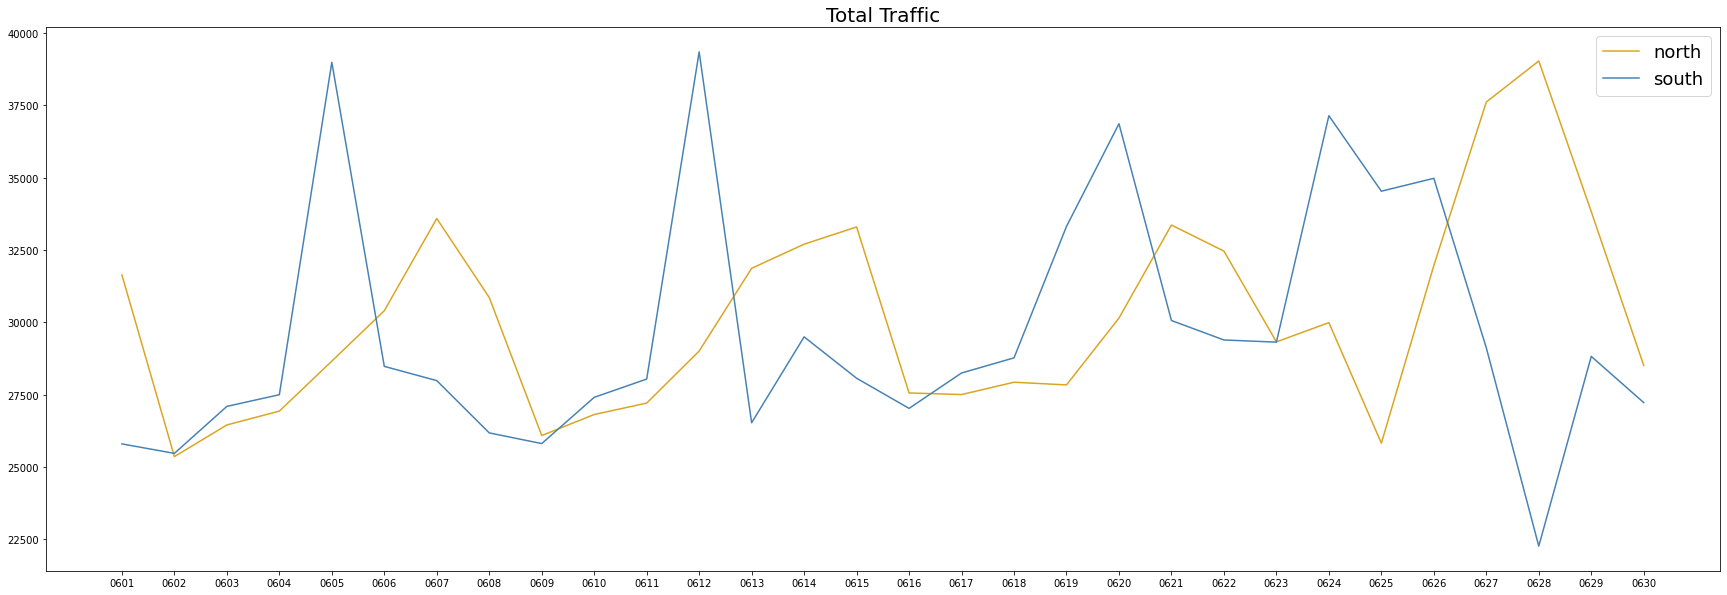

In [120]:
df_n_02 = df_n[df_n['road_level_to']=='0055'].groupby('mmdd')['Traffic'].sum().reset_index()
df_s_02 = df_s[df_s['road_level_from']=='0055'].groupby('mmdd')['Traffic'].sum().reset_index()

plt.figure(figsize=(30, 10))

color1 = 'goldenrod'
color2 = 'steelblue'
plt.plot(df_n_02['mmdd'], df_n_02['Traffic'], label='north', color=color1)
plt.plot(df_s_02['mmdd'], df_s_02['Traffic'], label='south', color=color2)

plt.legend(fontsize=18)
plt.title('Total Traffic', fontsize=20)

* 南下路段車速在假期前一天開始降低，假期第一天達到低點
* 端午連假第一天南下路段車速明顯低於平常例假日
* 北上路段通常在例假日最後一天達到低點
* 端午連假第三天北上路段車速也低，但與例假日相較差異較不明顯

Text(0.5, 1.0, 'Average Speed')

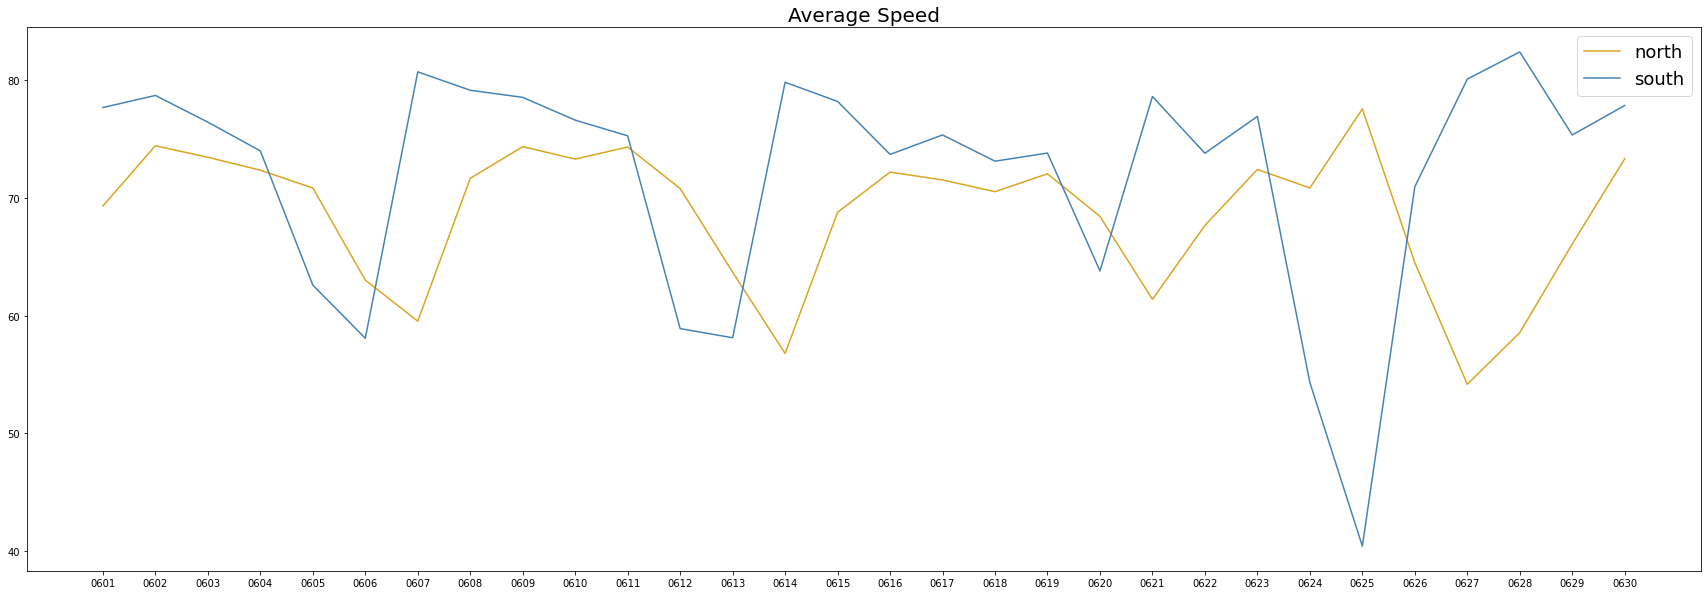

In [119]:
df_n_02 = df_n[df_n['road_level_to']=='0055'].groupby('mmdd')['avg_speed'].mean().reset_index()
df_s_02 = df_s[df_s['road_level_from']=='0055'].groupby('mmdd')['avg_speed'].mean().reset_index()

plt.figure(figsize=(30, 10))

color1 = 'goldenrod'
color2 = 'steelblue'
plt.plot(df_n_02['mmdd'], df_n_02['avg_speed'], label='north', color=color1)
plt.plot(df_s_02['mmdd'], df_s_02['avg_speed'], label='south', color=color2)

plt.legend(fontsize=18)
plt.title('Average Speed', fontsize=20)

* 觀察南下路段，車流與車速呈現高度負相關

Text(0.5, 1.0, 'Traffic vs. Speed')

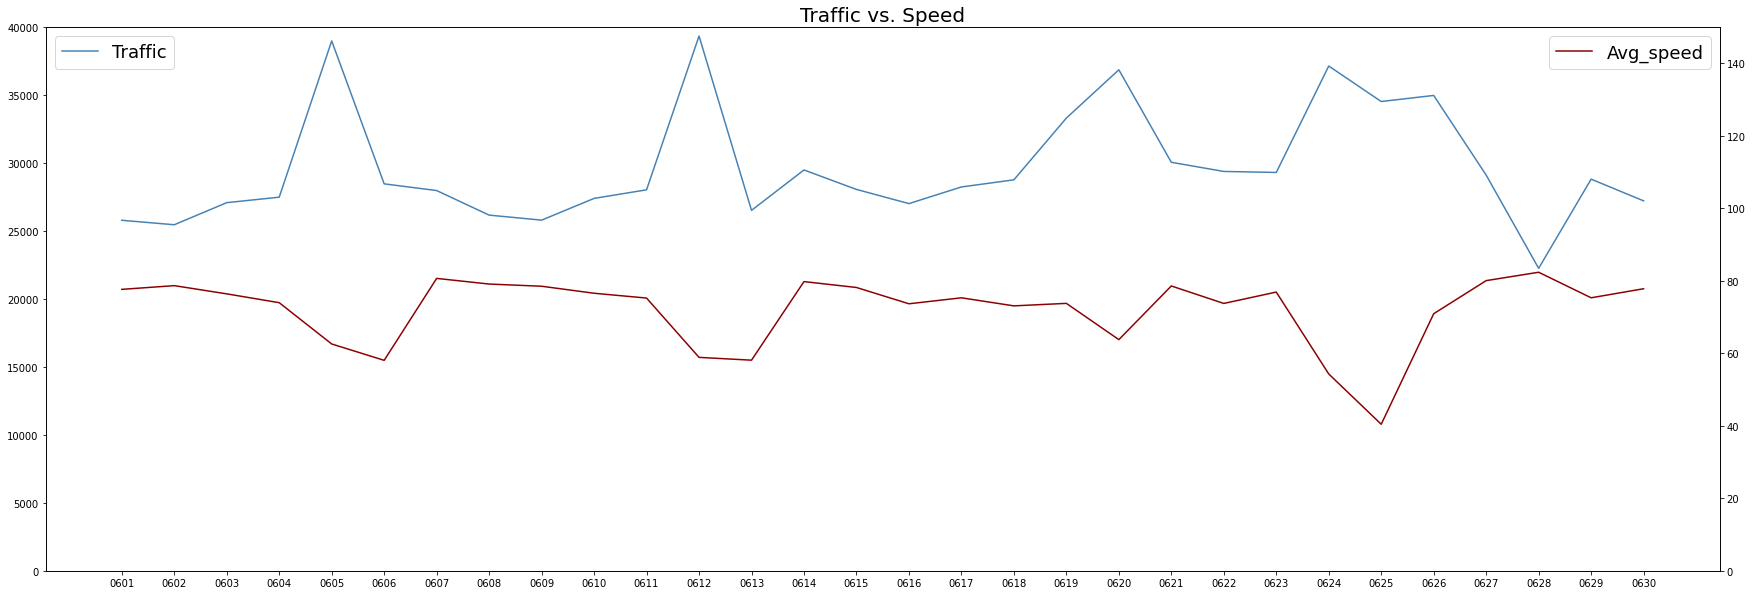

In [118]:
df_s_traffic = df_s[df_s['road_level_from']=='0055'].groupby('mmdd')['Traffic'].sum().reset_index()
df_s_speed = df_s[df_s['road_level_from']=='0055'].groupby('mmdd')['avg_speed'].mean().reset_index()

fig = plt.figure(figsize=(30, 10))

color1 = 'steelblue'
color2 = 'darkred'

ax1 = fig.add_subplot()
ax1.plot(df_s_traffic['mmdd'], df_s_traffic['Traffic'], label='Traffic', color=color1)
plt.ylim(0, 40000)
plt.legend(fontsize=18, loc='upper left')

ax2 = ax1.twinx()
ax2.plot(df_s_speed['mmdd'], df_s_speed['avg_speed'], label='Avg_speed', color=color2)
plt.ylim(0, 150)
plt.legend(fontsize=18)

plt.title('Traffic vs. Speed', fontsize=20)

### 例假日

* 例假日車流變化模式很一致
    * 週五早上車流就開始變大
    * 週六分成清晨與傍晚兩個高峰
    * 週日中午前為高峰

Text(0.5, 1.0, '0614 Traffic')

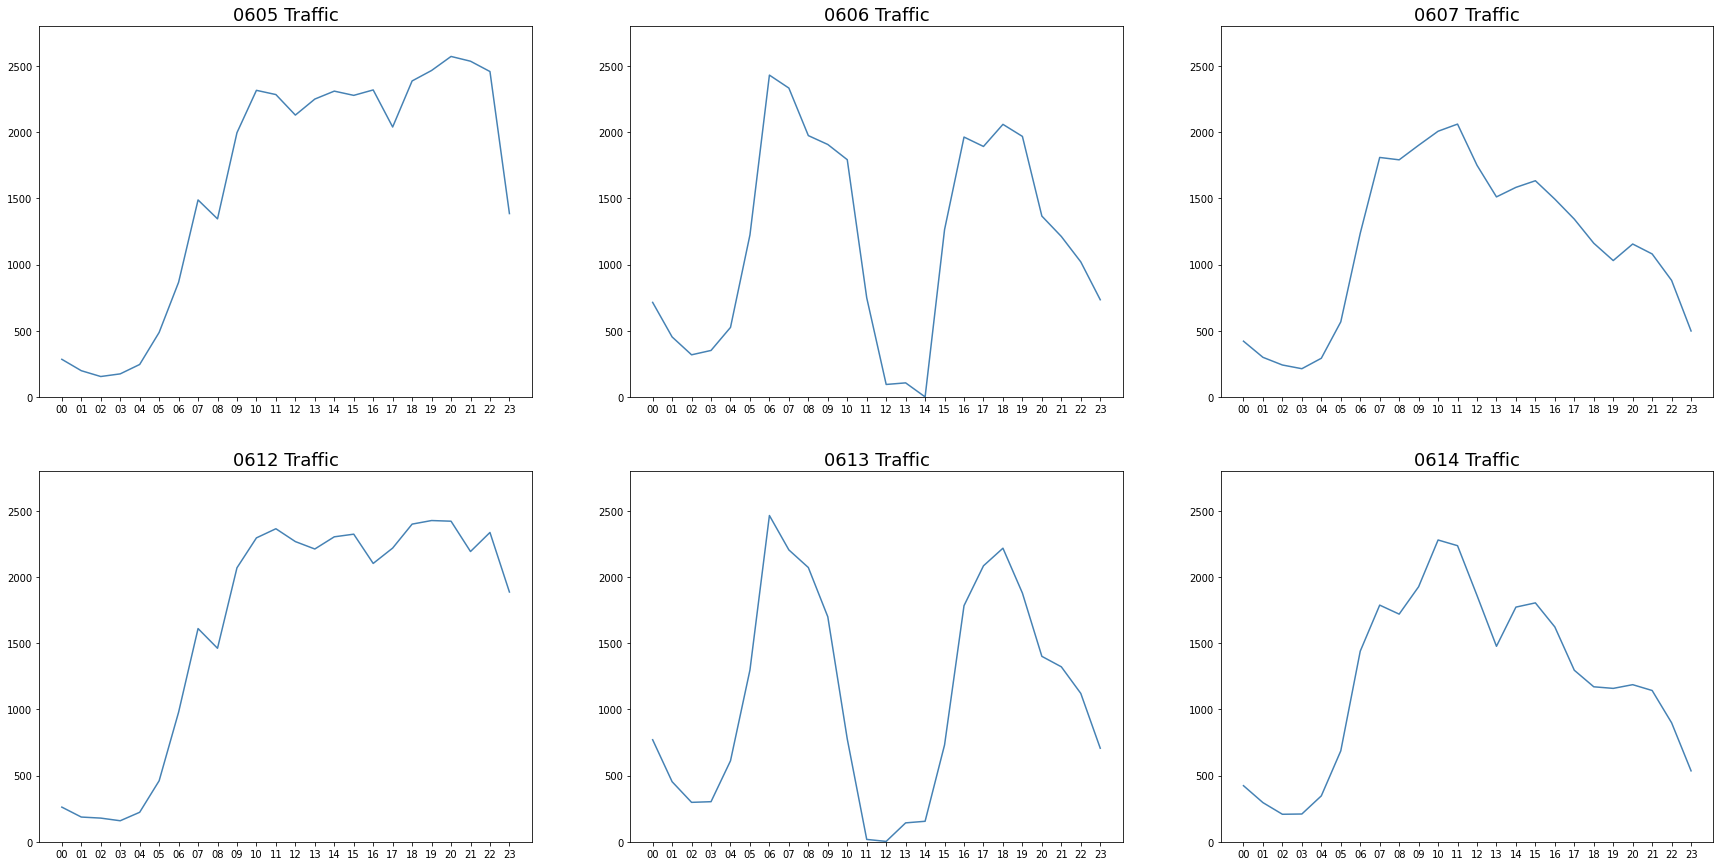

In [142]:
df_05 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0605')].groupby('hh')['Traffic'].sum().reset_index()
df_06 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0606')].groupby('hh')['Traffic'].sum().reset_index()
df_07 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0607')].groupby('hh')['Traffic'].sum().reset_index()

df_12 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0612')].groupby('hh')['Traffic'].sum().reset_index()
df_13 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0613')].groupby('hh')['Traffic'].sum().reset_index()
df_14 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0614')].groupby('hh')['Traffic'].sum().reset_index()

plt.figure(figsize=(30, 15))

color = 'steelblue'

plt.subplot2grid((2, 3), (0, 0))
plt.plot(df_05['hh'], df_05['Traffic'], color=color)
plt.ylim(0, 2800)
plt.title('0605 Traffic', fontsize=18)

plt.subplot2grid((2, 3), (0, 1))
plt.plot(df_06['hh'], df_06['Traffic'], color=color)
plt.ylim(0, 2800)
plt.title('0606 Traffic', fontsize=18)

plt.subplot2grid((2, 3), (0, 2))
plt.plot(df_07['hh'], df_07['Traffic'], color=color)
plt.ylim(0, 2800)
plt.title('0607 Traffic', fontsize=18)


plt.subplot2grid((2, 3), (1, 0))
plt.plot(df_12['hh'], df_12['Traffic'], color=color)
plt.ylim(0, 2800)
plt.title('0612 Traffic', fontsize=18)

plt.subplot2grid((2, 3), (1, 1))
plt.plot(df_13['hh'], df_13['Traffic'], color=color)
plt.ylim(0, 2800)
plt.title('0613 Traffic', fontsize=18)

plt.subplot2grid((2, 3), (1, 2))
plt.plot(df_14['hh'], df_14['Traffic'], color=color)
plt.ylim(0, 2800)
plt.title('0614 Traffic', fontsize=18)


Text(0.5, 1.0, '0614 average speed')

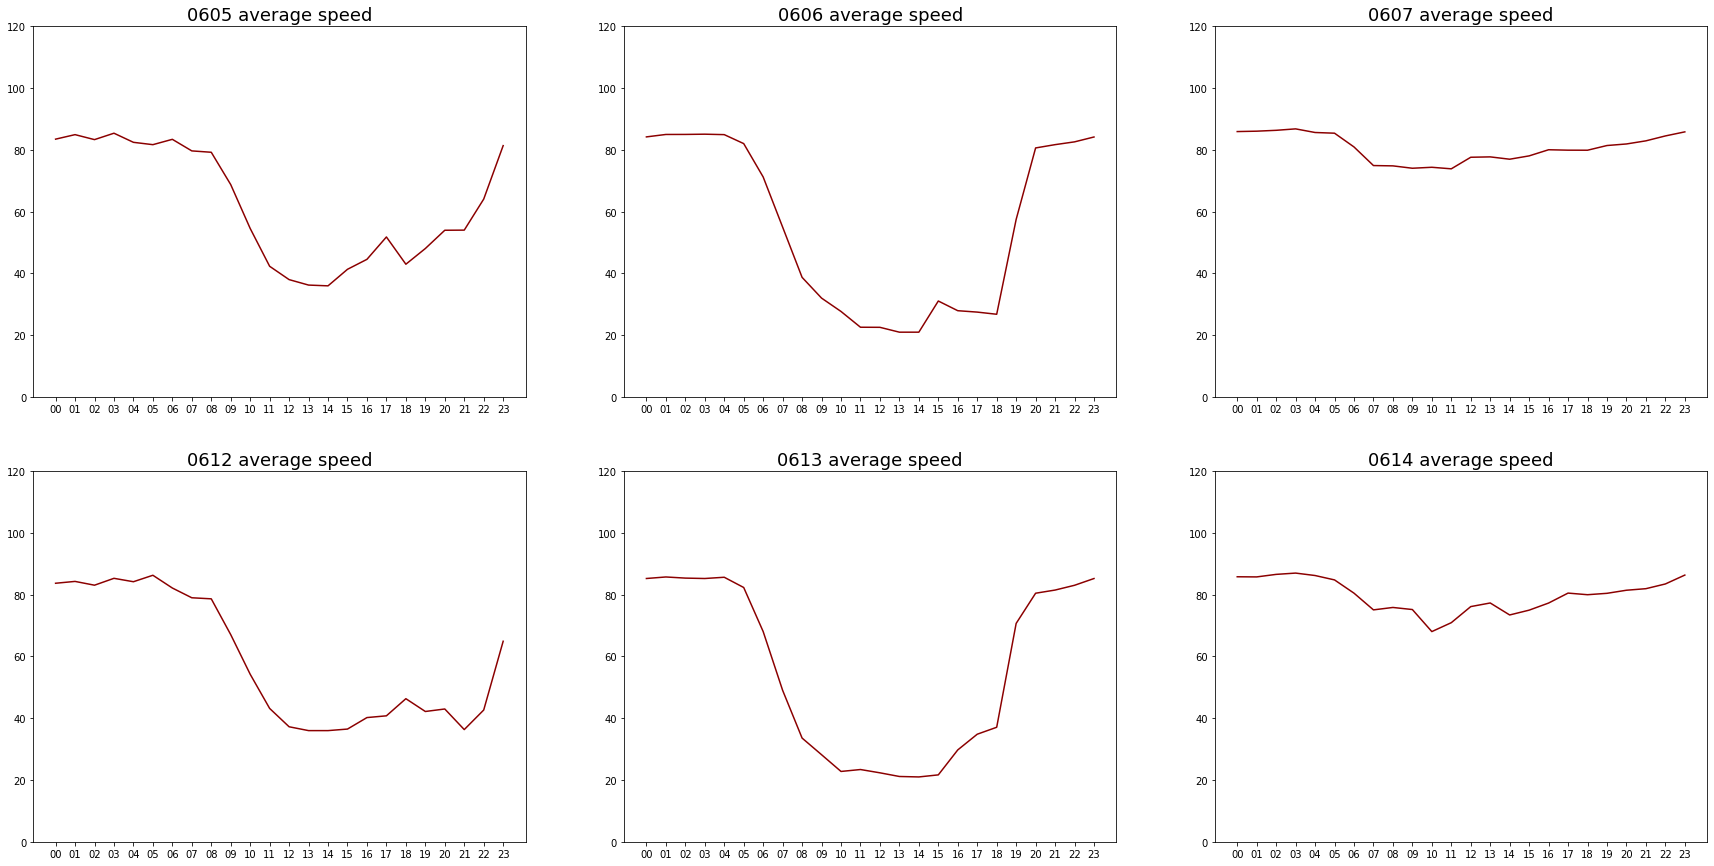

In [147]:
df_05 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0605')].groupby('hh')['avg_speed'].mean().reset_index()
df_06 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0606')].groupby('hh')['avg_speed'].mean().reset_index()
df_07 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0607')].groupby('hh')['avg_speed'].mean().reset_index()

df_12 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0612')].groupby('hh')['avg_speed'].mean().reset_index()
df_13 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0613')].groupby('hh')['avg_speed'].mean().reset_index()
df_14 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0614')].groupby('hh')['avg_speed'].mean().reset_index()

plt.figure(figsize=(30, 15))

color = 'darkred'

plt.subplot2grid((2, 3), (0, 0))
plt.plot(df_05['hh'], df_05['avg_speed'], color=color)
plt.ylim(0, 120)
plt.title('0605 average speed', fontsize=18)

plt.subplot2grid((2, 3), (0, 1))
plt.plot(df_06['hh'], df_06['avg_speed'], color=color)
plt.ylim(0, 120)
plt.title('0606 average speed', fontsize=18)

plt.subplot2grid((2, 3), (0, 2))
plt.plot(df_07['hh'], df_07['avg_speed'], color=color)
plt.ylim(0, 120)
plt.title('0607 average speed', fontsize=18)


plt.subplot2grid((2, 3), (1, 0))
plt.plot(df_12['hh'], df_12['avg_speed'], color=color)
plt.ylim(0, 120)
plt.title('0612 average speed', fontsize=18)

plt.subplot2grid((2, 3), (1, 1))
plt.plot(df_13['hh'], df_13['avg_speed'], color=color)
plt.ylim(0, 120)
plt.title('0613 average speed', fontsize=18)

plt.subplot2grid((2, 3), (1, 2))
plt.plot(df_14['hh'], df_14['avg_speed'], color=color)
plt.ylim(0, 120)
plt.title('0614 average speed', fontsize=18)


### 端午連假

* 連假前一天模式與週五相似
* 連假第一天模式與週六相似
* 連假第 2-3 天模式與週日相似

Text(0.5, 1.0, '0628 Traffic')

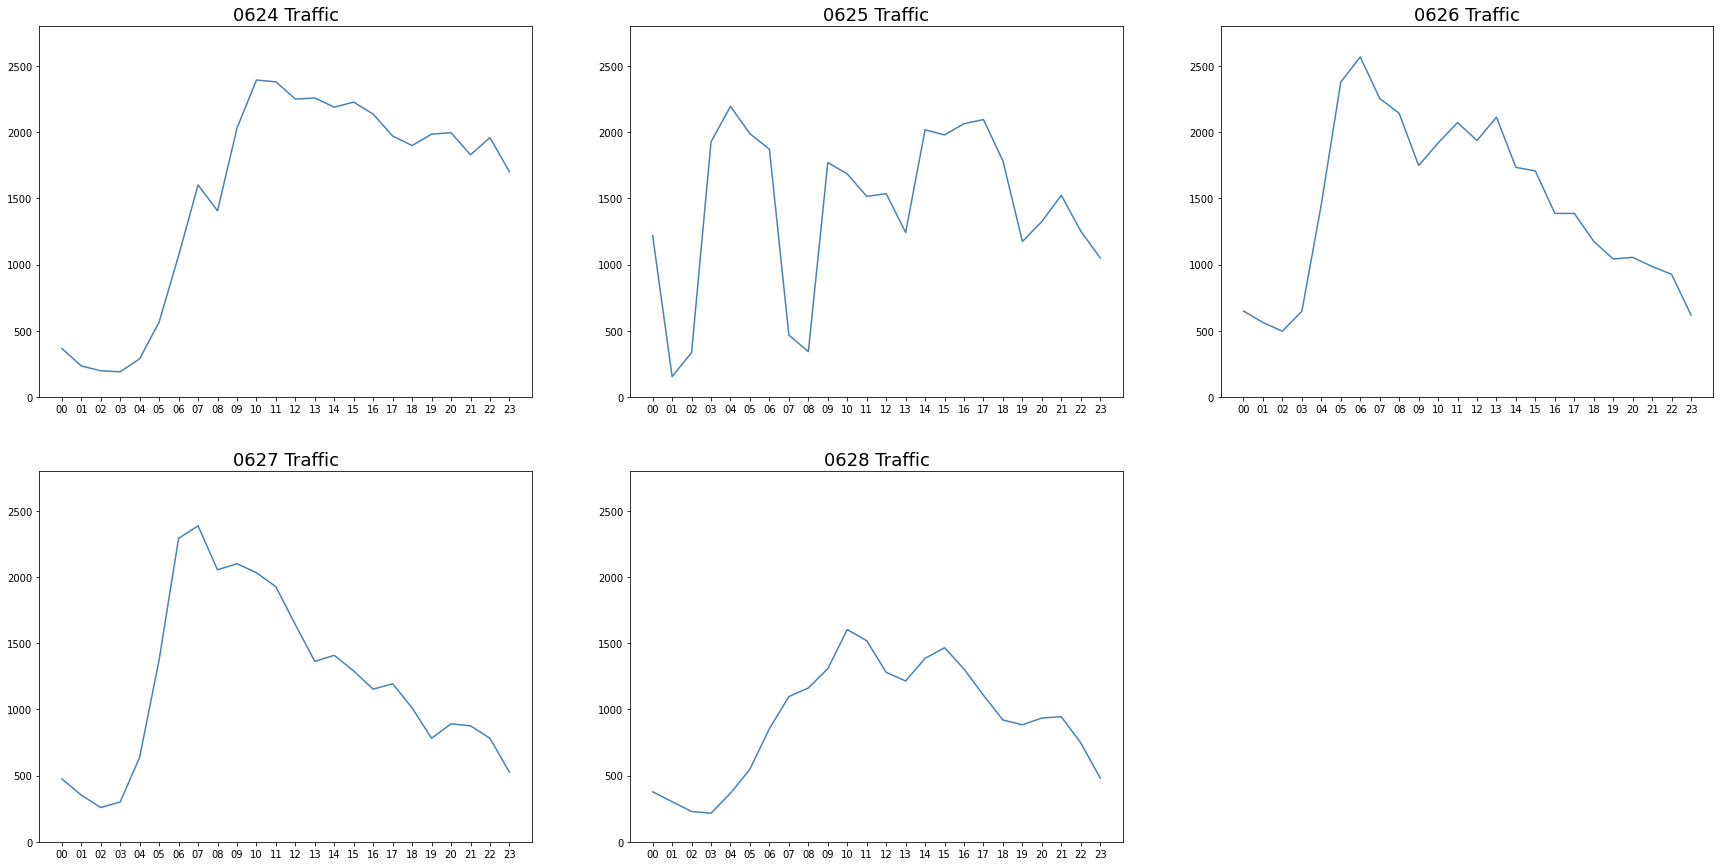

In [143]:
df_24 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0624')].groupby('hh')['Traffic'].sum().reset_index()
df_25 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0625')].groupby('hh')['Traffic'].sum().reset_index()
df_26 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0626')].groupby('hh')['Traffic'].sum().reset_index()
df_27 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0627')].groupby('hh')['Traffic'].sum().reset_index()
df_28 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0628')].groupby('hh')['Traffic'].sum().reset_index()

plt.figure(figsize=(30, 15))

color = 'steelblue'

plt.subplot2grid((2, 3), (0, 0))
plt.plot(df_24['hh'], df_24['Traffic'], color=color)
plt.ylim(0, 2800)
plt.title('0624 Traffic', fontsize=18)

plt.subplot2grid((2, 3), (0, 1))
plt.plot(df_25['hh'], df_25['Traffic'], color=color)
plt.ylim(0, 2800)
plt.title('0625 Traffic', fontsize=18)

plt.subplot2grid((2, 3), (0, 2))
plt.plot(df_26['hh'], df_26['Traffic'], color=color)
plt.ylim(0, 2800)
plt.title('0626 Traffic', fontsize=18)

plt.subplot2grid((2, 3), (1, 0))
plt.plot(df_27['hh'], df_27['Traffic'], color=color)
plt.ylim(0, 2800)
plt.title('0627 Traffic', fontsize=18)

plt.subplot2grid((2, 3), (1, 1))
plt.plot(df_28['hh'], df_28['Traffic'], color=color)
plt.ylim(0, 2800)
plt.title('0628 Traffic', fontsize=18)


Text(0.5, 1.0, '0628 average speed')

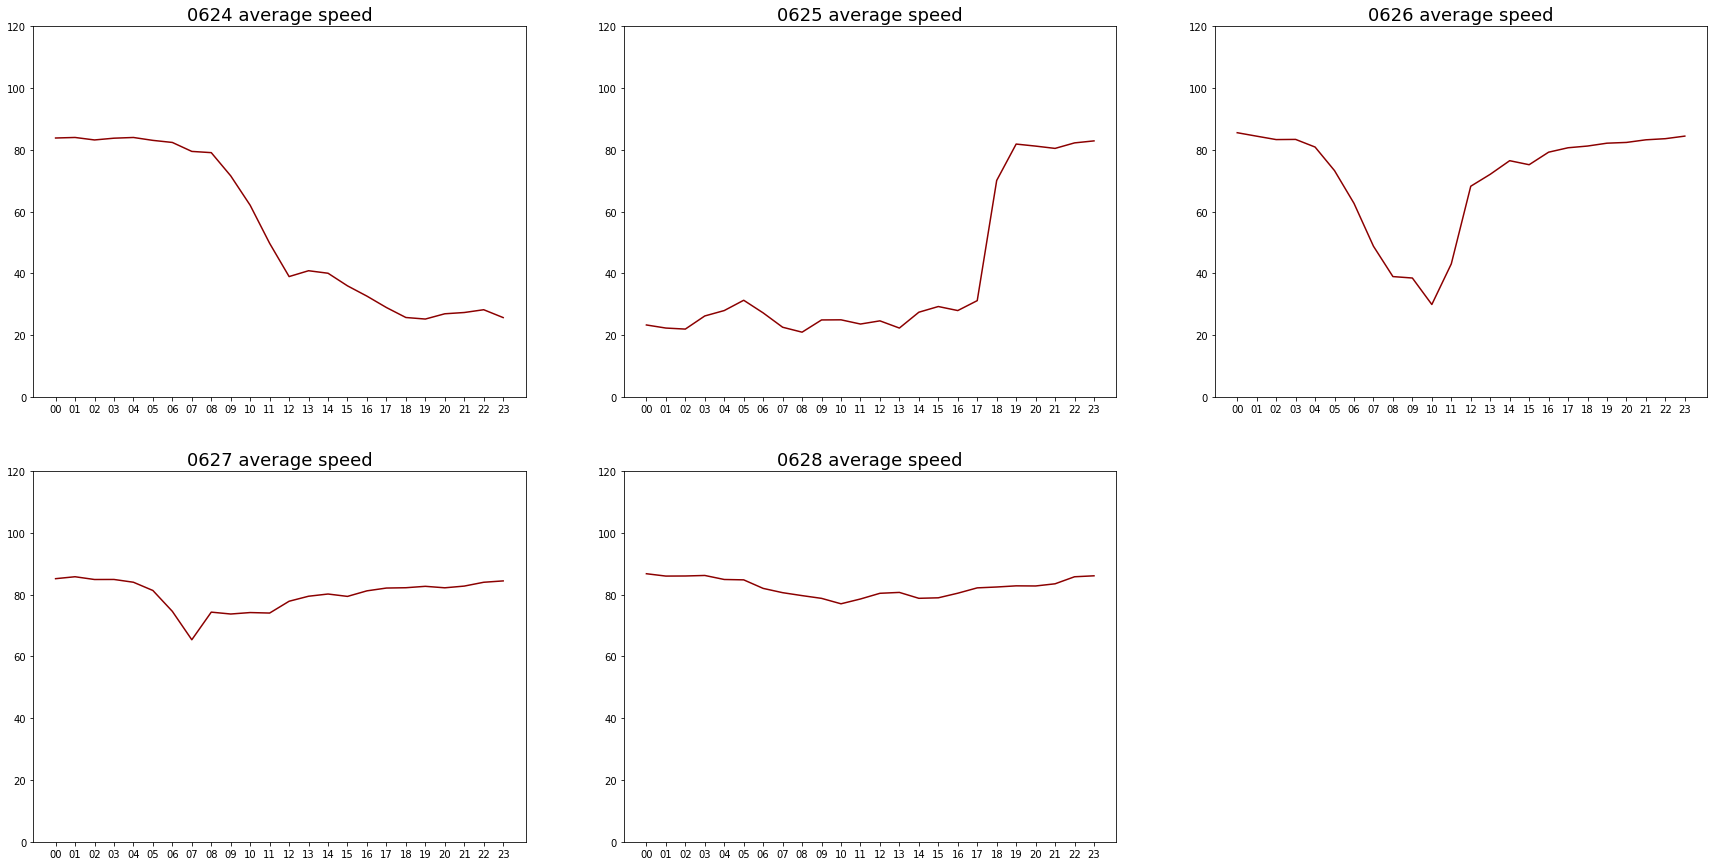

In [148]:
df_24 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0624')].groupby('hh')['avg_speed'].mean().reset_index()
df_25 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0625')].groupby('hh')['avg_speed'].mean().reset_index()
df_26 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0626')].groupby('hh')['avg_speed'].mean().reset_index()
df_27 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0627')].groupby('hh')['avg_speed'].mean().reset_index()
df_28 = df_s[(df_s['road_level_from']=='0055')&(df_s['mmdd']=='0628')].groupby('hh')['avg_speed'].mean().reset_index()

plt.figure(figsize=(30, 15))

color = 'darkred'

plt.subplot2grid((2, 3), (0, 0))
plt.plot(df_24['hh'], df_24['avg_speed'], color=color)
plt.ylim(0, 120)
plt.title('0624 average speed', fontsize=18)

plt.subplot2grid((2, 3), (0, 1))
plt.plot(df_25['hh'], df_25['avg_speed'], color=color)
plt.ylim(0, 120)
plt.title('0625 average speed', fontsize=18)

plt.subplot2grid((2, 3), (0, 2))
plt.plot(df_26['hh'], df_26['avg_speed'], color=color)
plt.ylim(0, 120)
plt.title('0626 average speed', fontsize=18)

plt.subplot2grid((2, 3), (1, 0))
plt.plot(df_27['hh'], df_27['avg_speed'], color=color)
plt.ylim(0, 120)
plt.title('0627 average speed', fontsize=18)

plt.subplot2grid((2, 3), (1, 1))
plt.plot(df_28['hh'], df_28['avg_speed'], color=color)
plt.ylim(0, 120)
plt.title('0628 average speed', fontsize=18)


In [157]:
df_s_weekend = df_s[(df_s['road_level_from']=='0055')&((df_s['mmdd']=='0605')|
                                            (df_s['mmdd']=='0606')|
                                            (df_s['mmdd']=='0612')|
                                            (df_s['mmdd']=='0613')|
                                            (df_s['mmdd']=='0624')|
                                            (df_s['mmdd']=='0625'))]

Text(0.5, 1.0, 'Traffic vs. average speed')

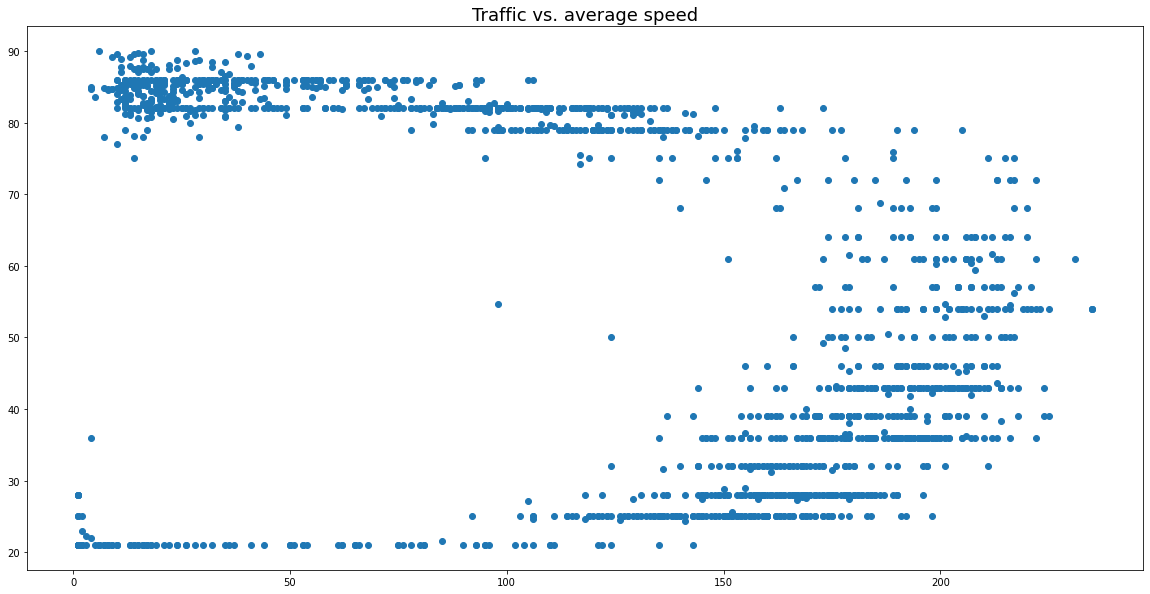

In [163]:
x = df_s_weekend['Traffic']
y = df_s_weekend['avg_speed']

plt.figure(figsize=(20, 10))
plt.scatter(x, y)
plt.title('Traffic vs. average speed', fontsize=18)

Text(0.5, 1.0, '22:00-24:00')

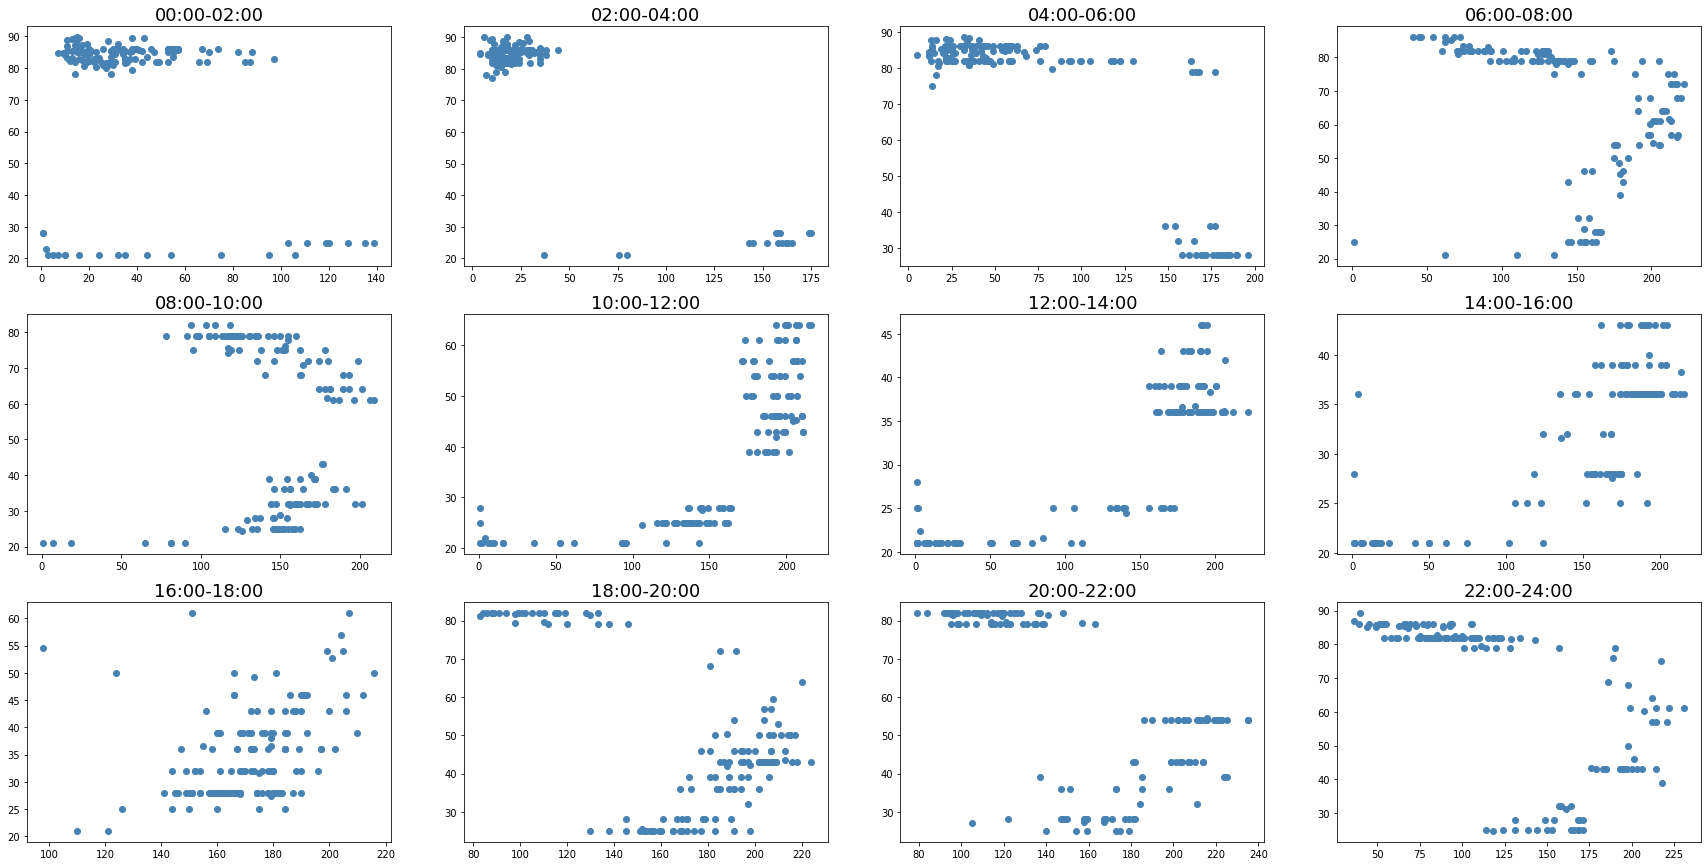

In [169]:
plt.figure(figsize=(30, 15))

color = 'steelblue'

plt.subplot2grid((3, 4), (0, 0))
plt.scatter(df_s_weekend[(df_s_weekend['hh']=='00')|(df_s_weekend['hh']=='01')]['Traffic'], 
         df_s_weekend[(df_s_weekend['hh']=='00')|(df_s_weekend['hh']=='01')]['avg_speed'], color=color)
plt.title('00:00-02:00', fontsize=18)

plt.subplot2grid((3, 4), (0, 1))
plt.scatter(df_s_weekend[(df_s_weekend['hh']=='02')|(df_s_weekend['hh']=='03')]['Traffic'], 
         df_s_weekend[(df_s_weekend['hh']=='02')|(df_s_weekend['hh']=='03')]['avg_speed'], color=color)
plt.title('02:00-04:00', fontsize=18)

plt.subplot2grid((3, 4), (0, 2))
plt.scatter(df_s_weekend[(df_s_weekend['hh']=='04')|(df_s_weekend['hh']=='05')]['Traffic'], 
         df_s_weekend[(df_s_weekend['hh']=='04')|(df_s_weekend['hh']=='05')]['avg_speed'], color=color)
plt.title('04:00-06:00', fontsize=18)

plt.subplot2grid((3, 4), (0, 3))
plt.scatter(df_s_weekend[(df_s_weekend['hh']=='06')|(df_s_weekend['hh']=='07')]['Traffic'], 
         df_s_weekend[(df_s_weekend['hh']=='06')|(df_s_weekend['hh']=='07')]['avg_speed'], color=color)
plt.title('06:00-08:00', fontsize=18)

plt.subplot2grid((3, 4), (1, 0))
plt.scatter(df_s_weekend[(df_s_weekend['hh']=='08')|(df_s_weekend['hh']=='09')]['Traffic'], 
         df_s_weekend[(df_s_weekend['hh']=='08')|(df_s_weekend['hh']=='09')]['avg_speed'], color=color)
plt.title('08:00-10:00', fontsize=18)

plt.subplot2grid((3, 4), (1, 1))
plt.scatter(df_s_weekend[(df_s_weekend['hh']=='10')|(df_s_weekend['hh']=='11')]['Traffic'], 
         df_s_weekend[(df_s_weekend['hh']=='10')|(df_s_weekend['hh']=='11')]['avg_speed'], color=color)
plt.title('10:00-12:00', fontsize=18)

plt.subplot2grid((3, 4), (1, 2))
plt.scatter(df_s_weekend[(df_s_weekend['hh']=='12')|(df_s_weekend['hh']=='13')]['Traffic'], 
         df_s_weekend[(df_s_weekend['hh']=='12')|(df_s_weekend['hh']=='13')]['avg_speed'], color=color)
plt.title('12:00-14:00', fontsize=18)

plt.subplot2grid((3, 4), (1, 3))
plt.scatter(df_s_weekend[(df_s_weekend['hh']=='14')|(df_s_weekend['hh']=='15')]['Traffic'], 
         df_s_weekend[(df_s_weekend['hh']=='14')|(df_s_weekend['hh']=='15')]['avg_speed'], color=color)
plt.title('14:00-16:00', fontsize=18)

plt.subplot2grid((3, 4), (2, 0))
plt.scatter(df_s_weekend[(df_s_weekend['hh']=='16')|(df_s_weekend['hh']=='17')]['Traffic'], 
         df_s_weekend[(df_s_weekend['hh']=='16')|(df_s_weekend['hh']=='17')]['avg_speed'], color=color)
plt.title('16:00-18:00', fontsize=18)

plt.subplot2grid((3, 4), (2, 1))
plt.scatter(df_s_weekend[(df_s_weekend['hh']=='18')|(df_s_weekend['hh']=='19')]['Traffic'], 
         df_s_weekend[(df_s_weekend['hh']=='18')|(df_s_weekend['hh']=='19')]['avg_speed'], color=color)
plt.title('18:00-20:00', fontsize=18)

plt.subplot2grid((3, 4), (2, 2))
plt.scatter(df_s_weekend[(df_s_weekend['hh']=='20')|(df_s_weekend['hh']=='21')]['Traffic'], 
         df_s_weekend[(df_s_weekend['hh']=='20')|(df_s_weekend['hh']=='21')]['avg_speed'], color=color)
plt.title('20:00-22:00', fontsize=18)

plt.subplot2grid((3, 4), (2, 3))
plt.scatter(df_s_weekend[(df_s_weekend['hh']=='22')|(df_s_weekend['hh']=='23')]['Traffic'], 
         df_s_weekend[(df_s_weekend['hh']=='22')|(df_s_weekend['hh']=='23')]['avg_speed'], color=color)
plt.title('22:00-24:00', fontsize=18)
